## Solve 1-D convection equation

$$\frac{\partial y}{\partial t} = -\frac{\partial uy}{\partial x},$$

where $u=u_0(1-y)$ is the wave speed, and $y$ is the scalar being solved.

* Solve using a finite volume method:
$$\frac{dy}{dt} = -\frac{f_e-f_w}{\Delta x},$$
where $f=uy$ is the flux of $y$, and $e$ and $w$ denote east and west faces.
* The initial condition is a uniform profile.
* The boundary conditions are zero flux conditions.
* The velocity is such that when $y=0$ $u=u_0$, and when $y=1$, $u=0$. 
* The problem is solved using an upwind method. 
* To enforce conservation, a flux limiter is set to that any cell with $y\ge 0$ has $f_w=0$.
    * That is, the incoming flux is 0 if the cell is "full"
* Solving on the following domain:

```
|-----------------------------|
|  *  |  *  |  *  |  *  |  *  |
|-----------------------------|
x=0                         x=L
```


In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from scipy.misc import derivative
%matplotlib inline
np.set_printoptions(precision=4)

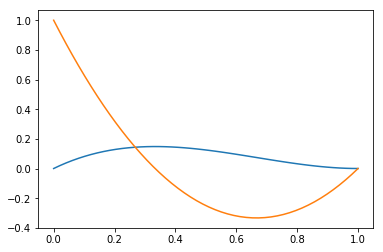

In [2]:
def flux(y): return y*(1-y)**2
def celerity(y): return 1-4*y+3*y**2
concs = np.linspace(0,1)
plt.plot(concs,flux(concs));
plt.plot(concs,celerity(concs));
# maximum occurs at y = 0.29

nts =  75
[0.    0.009 0.009 0.009 0.009 0.009 0.   ]
[0.     0.0092 0.009  0.009  0.009  0.009  0.    ]
[0.     0.0093 0.009  0.009  0.009  0.009  0.    ]
[0.     0.0095 0.009  0.009  0.009  0.009  0.    ]


(0, 1.0)

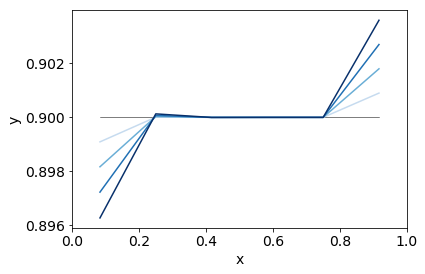

In [3]:
L   = 1.0          # domain length
nx  = 6            # number of grid points
cfl = 0.1          # timestep multiplier
u0  = 1.0          # base speed
y0  = 0.9          # base y

#------------- set t, x grids

dx = L/nx                           # grid spacing
x  = np.linspace(dx/2, L-dx/2, nx)  # grid points

tend = L/u0 * 0.025*50
Δt   = cfl*dx/u0                    # approximate step size
nts  = int(tend/Δt)                 # integer number of steps
Δt   = tend/nts                     # step size using nts
t    = np.linspace(0.0, tend, nts+1)
print('nts = ',nts)

#------------- Initial profiles

yinit = y0*np.ones(nx)              # initial profile
y     = yinit.copy()                # solution (updates at each timestep)

# print(f'initial mass of y on domain = {np.sum(y*dx)}')

#------------- 

def rk4step(rhsf, y):               # 4th order Runge-Kutta solver
    
    δy1 = rhsf(y,Δt) # intermediate function evaluation so that I can unpack the flux
    Δy1,f = Δt*δy1[0],δy1[1]
    Δy2 = Δt*rhsf(y + 0.5*Δy1, Δt/2)[0]
    Δy3 = Δt*rhsf(y + 0.5*Δy2, Δt/2)[0]
    Δy4 = Δt*rhsf(y +     Δy3, Δt)[0]
    Δy  = 1/6*(Δy1 + 2*Δy2 + 2*Δy3 + Δy4)
    print(f)

    return y + Δy
    
#------------- 

def rhsf(y, h):                      # right-hand-side function: -(f-f)/dx
    
    u = u0*(1.0-y)**2                # compute velocity as function of concentration
    
    f = np.hstack((0,(y*u)[:-1]))    # compute flux=uy at inner points and set left boundary flux to 0
    f[y>=1] = 0.0                    # makeshift limiter
    f = np.hstack((f,0))             # set right-side flux=0
    
    dydt = -1.0/dx*(f[1:] - f[:-1])
    return dydt,f

# -------------                       # solve the problem: advance in time
ystore = np.empty((nx,nts))
ystore[:,0] = yinit
ndebug = 4                           # temporary variable for computing/plotting only the first few time steps
for i in range(ndebug):
    y = rk4step(rhsf, y)
    ystore[:,i] = y
    
# -------------                       # Plot results

# print(f'final   mass of y on domain = {np.sum(y*dx)}')

plt.rc('font', size=14)
blue = iter(plt.cm.Blues(np.linspace(0.25,1,ndebug)))
plt.plot(x,yinit, 'k-', linewidth=0.5)
[plt.plot(x,ystore[:,i],color=next(blue)) for i in range(ndebug)]
plt.ylabel('y')
plt.xlabel('x')
plt.xlim([0,L])
# plt.ylim([0,1.1]);

#### Ignore everything below here

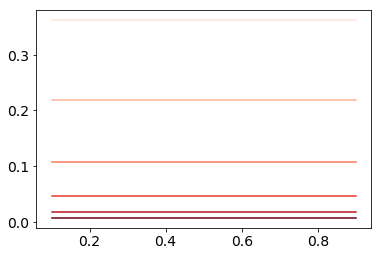

In [32]:
def get_ρ(ρ): 
    return ρ

def get_c(ρ):
    c = np.ones(len(ρ))
    v = (1-ρ)**2
    return v

def get_q(ρ):
    return  get_c(ρ) * ρ

def godunov(ρ,t):
    ρ_bc = np.zeros(ngrd+2)
    ρ_bc[-1] = 1.0
    ρ_bc[1:-1] = ρ

    q = get_q(ρ_bc)
    
    # evaluate fluxes at each cell wall 
    qf = np.zeros(ngrdf)
    for i in range(ngrdf):
        if ρ_bc[i] >= ρ_bc[i+1]:
            qf[i] = max(q[i],q[i+1])
        elif ρ_bc[i] <= 0 and 0 <= ρ_bc[i+1]:
            qf[i] = 0
        else:
            qf[i] = min(q[i],q[i+1])
            
    dρdt = 1/Δx*(qf[:-1]-qf[1:])
    return dρdt

def rk4step(rhsf, y, Δt=None):               # 4th order Runge-Kutta solver
    
    Δy1 = Δt*rhsf(y,           Δt)[0]
    Δy2 = Δt*rhsf(y + 0.5*Δy1, Δt/2)[0]
    Δy3 = Δt*rhsf(y + 0.5*Δy2, Δt/2)[0]
    Δy4 = Δt*rhsf(y +     Δy3, Δt)[0]    
    return y + 1/6*(Δy1 + 2*Δy2 + 2*Δy3 + Δy4)

ngrd = 5
L    = 1
tend = 1
ntimes = 6

times = np.linspace(0,tend,ntimes)
Δt    = times[1]-times[0]
ngrdf = ngrd+1
Δx    = L/ngrd
xf    = np.linspace(0,L,ngrdf)
x     = (xf[1:] + xf[:-1])/2

ρ0  = np.ones(ngrd)*0.5
ρstore = np.empty((ngrd,ntimes))
ρstore[:,0] = ρ0
ρcalc  = ρ0.copy()
reds = plt.get_cmap('Reds')
reds = iter(reds(np.linspace(0.1,1,ntimes)))
for i,t in enumerate(times):
    ρcalc = rk4step(godunov,ρcalc,Δt)
    ρstore[:,i] = ρcalc
    
[plt.plot(x,ρstore[:,i],color=next(reds)) for i in range(ntimes)]
plt.show()

In [29]:
ρstore

array([[0.219 , 0.0539, 0.0169, 0.0056, 0.0019, 0.0006],
       [0.219 , 0.0539, 0.0169, 0.0056, 0.0019, 0.0006],
       [0.219 , 0.0539, 0.0169, 0.0056, 0.0019, 0.0006],
       [0.219 , 0.0539, 0.0169, 0.0056, 0.0019, 0.0006],
       [0.219 , 0.0539, 0.0169, 0.0056, 0.0019, 0.0006]])